In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import csv

import qiskit
from qiskit_experiments import library
import qiskit.quantum_info as qi
from qiskit.circuit.library import XGate, YGate, ZGate, U1Gate
from qiskit.quantum_info import Choi, Kraus
#import qiskit.aqua.utils as utils
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumCircuit, QuantumRegister,execute, Aer
import qiskit.quantum_info.operators.channel.transformations as qtrans
from qiskit_aer import AerSimulator

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
#Pauli matrices:
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])


# 2 Qubit-channel

Now we will use the algorithm to simulate a 2-qubit quantum channel. In particular, the channel we will simulate is 

$$ \varepsilon(\rho) = (1-p) \rho + \frac{p}{3} (\sigma_3 \otimes I) \rho (\sigma_3 \otimes I) + \frac{p}{3}  (I \otimes \sigma_3) \rho (I \otimes \sigma_3) + \frac{p}{3}  (\sigma_3 \otimes \sigma_3) \rho (\sigma_3 \otimes \sigma_3) $$

To simulate this particular channel, we will need the two principal qubits and two ancilla qubits (to create the probabilities $1-p, p/3, p/3, p/3$). 


In [5]:
"""Function to create the circuit given the value of p.
See code 'Simulation of Pauli Channels' """

def ks_to_circuit(p):
    
    
    #We calculate the angles theta0, theta1, theta2.
    theta0 = np.angle(np.sqrt(1-p)+1j*np.sqrt(p/3))
    theta1 = 2*np.arccos(np.sqrt(1-p+p/3))
    theta2 = np.angle(np.sqrt(1-p)+1j*np.sqrt(p/3))
    
    # We create the circuit with 3 qubits.
    qreg_q = QuantumRegister(4, 'q') 
    circ = QuantumCircuit(qreg_q)
    
    #Add the quantum gates to create the ancilla qubit state.
    circ.ry(theta1,2)
    circ.ry(theta0,3)
    circ.cz(2,3)
    circ.ry(theta2,3)
    
    #Add the controlled gates.
    ciz = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='01')
    czi = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='10')
    
    ciz11 = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    czi11 = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    
    circ.append(ciz, [2,3, 0])
    circ.append(czi, [2,3, 1])

    circ.append(czi11, [2,3, 0])
    circ.append(czi11, [2,3, 1])

    return(circ)



Create many instances of the channel for different values of $p$

In [7]:
ps = np.linspace(0,1,25)

circuits = []
for p in ps:
    circuits.append(ks_to_circuit(p))



### Run Quantum Process tomography

In [8]:
def choi_theoretical(p):
    '''For a value of p describing the Pauli channel, this function
    returns the choi matrix of said channel.
    '''

    k = Kraus([np.sqrt(1-p)*np.kron(I,I),np.sqrt(p/3)*np.kron(Z,I),
                               np.sqrt(p/3)*np.kron(I,Z),np.sqrt(p/3)*np.kron(Z,Z)])
    
    #We convert the Kraus representation to the choi representation of the channel.
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(qi.Choi(mat_choi))



In [12]:
from qiskit_experiments.library import ProcessTomography
import qiskit
from qiskit_aer import AerSimulator

from qiskit import IBMQ
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [ ]:
computer = "ibmq_lima"
backend = provider.get_backend(computer)

reps = 10

fidelities = []
for i in range(len(ps)):
    p = ps[i]
    circ = circuits[i]
    
    print(i)
    for r in range(reps):
        print(r)
        
    
    
        qpt = ProcessTomography(circ,backend,measurement_indices=[0,1],
                            preparation_indices=[0,1])
        qpt.set_run_options(shots=20000)
    
        qpt_run = qpt.run()
        qptdata = qpt_run.block_for_results()
    
    
        
        choi_simu = qptdata.analysis_results("state").value
        choi_theo = choi_theoretical(p)
    
        dis =qi.diamond_norm(qi.Choi(choi_simu)-choi_theo)
        fidelities.append(1-0.5*dis)
        
        with open("Results/2Qubits/fidelity-2qbit-izzizz.csv","a") as f:
            f.write(str(dis)+ ",")
            
    with open("Results/2Qubits/fidelity-2qbit-izzizz.csv","a") as f:
        f.write("\n")
    
    

In [3]:
import csv

res = []
with open("Results/2Qubits/fidelity-2qbit-izzizz.csv","r") as f:
    reader_obj = csv.reader(f)
    print(reader_obj)
    for a in reader_obj:
        c = []
        for i in range(len(a)):
            c.append(float(a[i]))
        res.append(c)
        
res


[[0.908678356488016,
  0.8641934338576971,
  0.9025796799652274,
  0.8785133528179392,
  0.8921454599889455,
  0.8376180984601942,
  0.8883576433295284,
  0.8319105449055767,
  0.8539692544470792,
  0.8789958781709001],
 [0.8345383248615662,
  0.8257239747030007,
  0.8071687915414353,
  0.8059645946738769,
  0.9098410430255026,
  0.8026235862729061,
  0.814681758957651,
  0.8753271114919384,
  0.8296239379847906,
  0.8262291716925976],
 [0.8242178379529063,
  0.7987339334763208,
  0.81032472495756,
  0.8615073165395519,
  0.8300130042123974,
  0.8082367453743935,
  0.8465258263534268,
  0.7970945290394882,
  0.9104984773123814,
  0.8035639283801612],
 [0.7504114149336455,
  0.8279014774275766,
  0.8014658285643239,
  0.7586938235629375,
  0.8882097408725246,
  0.7965407787509281,
  0.8492444886367728,
  0.8458715540663857,
  0.8833634126327135,
  0.7677353078511199],
 [0.73511014085954,
  0.7723745473702003,
  0.764063907406218,
  0.7703381680953806,
  0.7615137253328861,
  0.748471812

Text(0, 0.5, 'f')

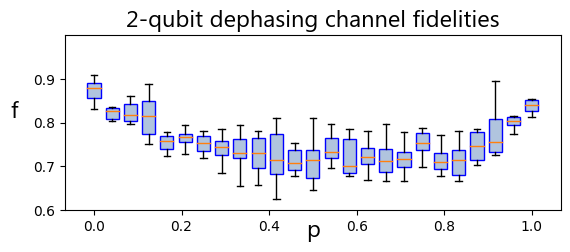

In [32]:
import pandas as pd

plt.boxplot(np.array(res).T,
            positions= np.linspace(0,1,25),
            widths=0.03, showcaps =True,
           manage_ticks=False,
           showfliers =False,patch_artist=True,
            boxprops=dict(facecolor="lightsteelblue", color="blue"));

plt.ylim([0.6,1])
plt.yticks([0.6,0.7,0.8,0.9])
plt.gca().set_aspect('equal')
plt.title("2-qubit dephasing channel fidelities",fontname='Microsoft Tai Le',fontsize=17)
plt.xlabel("p",fontsize=17,fontname='Microsoft Tai Le',labelpad=-10)
plt.ylabel("f",fontsize=17,fontname='Microsoft Tai Le',rotation=0,labelpad=14)